<a href="https://colab.research.google.com/github/bakhadir0v/comp215-1-/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s): Ata
#### Date: 29.01.2025

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [53]:
# import necessary modules
import matplotlib.pyplot as plt
import json, requests
from dataclasses import dataclass
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [44]:
#API_KEY = 'DEMO_KEY'  # substitute your API key here
API_KEY = '9FJ4JxFTJsq7dEB6zpPemkbnZlCdXZyh6XbTnfrG'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2025-01-25'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo('54339874')#neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID 54339874 is:") #{neos[-1]['id']}
pprint((neo))
#print((neo['close_approach_data']))

102 Near Earth Objects found for week of 2025-01-25
Record for NEO ID 54339874 is:
{'absolute_magnitude_h': 24.86,
 'close_approach_data': [{'close_approach_date': '1949-07-04',
                          'close_approach_date_full': '1949-Jul-04 22:19',
                          'epoch_date_close_approach': -646710060000,
                          'miss_distance': {'astronomical': '0.419726307',
                                            'kilometers': '62790161.51016609',
                                            'lunar': '163.273533423',
                                            'miles': '39015997.166588442'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '73509.6739172087',
                                                'kilometers_per_second': '20.4193538659',
                                                'miles_per_hour': '45676.0526626122'}},
                         {'close_approach_date': '1950-0

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [47]:
# Ex. 1 your code here
from datetime import datetime

class CloseApproach:
    def __init__(self, neo_id, orbiting_body, approach_date, miss_distance, relative_velocity):
        self.id = neo_id
        self.orbiting_body = orbiting_body
        self.approach_date = datetime.strptime(approach_date, "%Y-%b-%d %H:%M")
        self.miss_distance = float(miss_distance)
        self.relative_velocity = float(relative_velocity)

    def __str__(self):
        return (f"NEO:\n"
                f"  ID: {self.id}\n"
                f"  Orbiting Body: {self.orbiting_body}\n"
                f"  Approach Date: {self.approach_date}\n"
                f"  Miss Distance: {self.miss_distance:.2f} km\n"
                f"  Relative Velocity: {self.relative_velocity:.2f} km/h")

    def __repr__(self):
        return (f"NEO(id='{self.id}', Orbiting Body='{self.orbiting_body}', "
                f"Approach Date={self.approach_date}, "
                f"Miss Distance={self.miss_distance:.2f} km, "
                f"Relative Velocity={self.relative_velocity:.2f} km/h)")

    @classmethod
    def from_NEO(cls, neo, close_approach_record):
        neo_id = neo['id']
        orbiting_body = close_approach_record['orbiting_body']
        approach_date = close_approach_record['close_approach_date_full']
        miss_distance = close_approach_record['miss_distance']['kilometers']
        relative_velocity = close_approach_record['relative_velocity']['kilometers_per_hour']
        return cls(neo_id, orbiting_body, approach_date, miss_distance, relative_velocity)

#neo1 = CloseApproach(neo['id'], neo['close_approach_data'][0]['orbiting_body'], neo['close_approach_data'][0]['close_approach_date_full'], neo['close_approach_data'][0]['miss_distance']['kilometers'], neo['close_approach_data'][0]['relative_velocity']['kilometers_per_hour'])
close_approach_record = neo['close_approach_data'][0]
neo1 = CloseApproach.from_NEO(neo, close_approach_record)
print(neo1)

NEO:
  ID: 54339874
  Orbiting Body: Earth
  Approach Date: 1949-07-04 22:19:00
  Miss Distance: 62790161.51 km
  Relative Velocity: 73509.67 km/h


## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [35]:
# Ex. 2 your code here
class Asteroid:
    def __init__(self, close_approaches=None):
        self.close_approaches = close_approaches if close_approaches is not None else []

    def __str__(self):
        return (f"Number of Close Approaches: {len(self.close_approaches)}")

    def __repr__(self):
        return (f"Asteroid(id='{self.id}', name='{self.name}', "
                f"close_approaches={self.close_approaches})")

    @classmethod
    def from_NEO(cls, close_approach_data):
        close_approach_data = neos
        close_approaches = [approach for approach in close_approach_data]
        return cls(close_approaches)

    def nearest_miss(self):
        misses = [float(entry['close_approach_data'][0]['miss_distance']['kilometers']) for entry in self.close_approaches]
        return min(misses)

    def closest_earth_approach(self):
        misses = [float(entry['close_approach_data'][0]['miss_distance']['kilometers']) for entry in self.close_approaches]
        closest_asteroid = [miss for miss in self.close_approaches if miss['close_approach_data'][0]['orbiting_body'] == 'Earth' and float(miss['close_approach_data'][0]['miss_distance']['kilometers']) == min(misses)]
        return (closest_asteroid)

close_approach_data = neos
asteroid = Asteroid.from_NEO(close_approach_data)
print(asteroid)
print("Nearest Miss:", asteroid.nearest_miss())
print("Closest Earth Approach:")
pprint(asteroid.closest_earth_approach())

Number of Close Approaches: 102
Nearest Miss: 9711.953559548
Closest Earth Approach:
[{'absolute_magnitude_h': 31.799,
  'close_approach_data': [{'close_approach_date': '2025-01-26',
                           'close_approach_date_full': '2025-Jan-26 01:10',
                           'epoch_date_close_approach': 1737853800000,
                           'miss_distance': {'astronomical': '0.0000649204',
                                             'kilometers': '9711.953559548',
                                             'lunar': '0.0252540356',
                                             'miles': '6034.7281078424'},
                           'orbiting_body': 'Earth',
                           'relative_velocity': {'kilometers_per_hour': '75769.1152420849',
                                                 'kilometers_per_second': '21.0469764561',
                                                 'miles_per_hour': '47079.9816347277'}}],
  'estimated_diameter': {'feet': {'estimated_d

## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

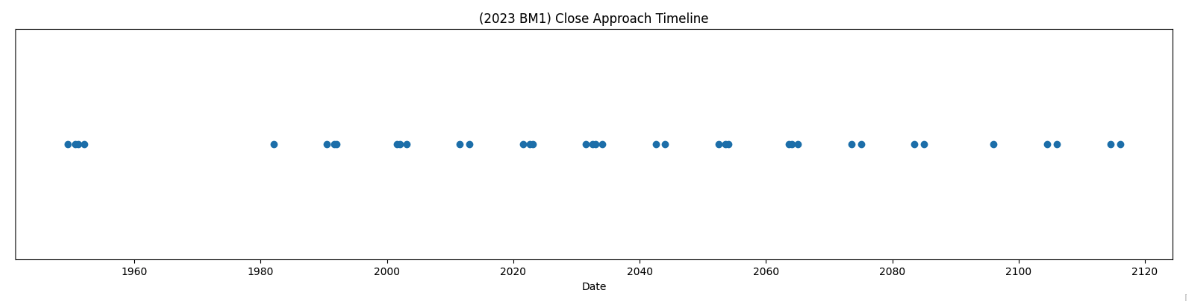

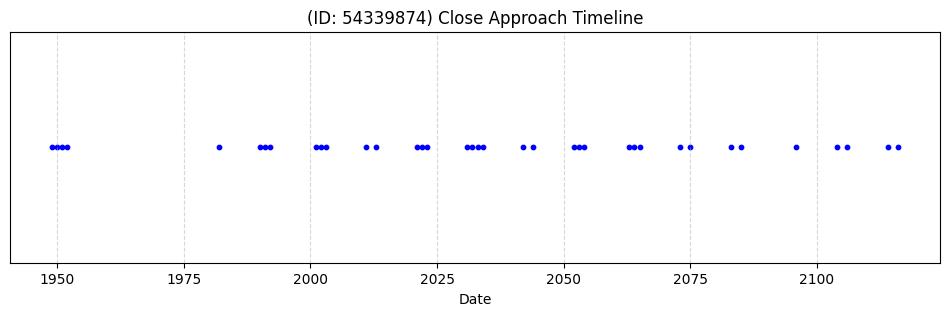

In [62]:
# Ex. 3 your code here
def closest_approaches(id):
  asteroid = get_neo(id)
  approaches = [approaches['close_approach_date'] for approaches in asteroid['close_approach_data']]
  years = [int(approach[:4]) for approach in approaches]
  y_values = [0] * len(years)

  plt.figure(figsize=(12, 3))
  plt.scatter(years, y_values, color='blue', marker='o', s = 10)

  plt.xlabel("Date")
  plt.yticks([])
  plt.title(f'(ID: {id}) Close Approach Timeline')
  plt.grid(axis="x", linestyle="--", alpha=0.5)

  plt.show()

(closest_approaches('54339874'))

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [ ]:
# Ex. 5 (challenge) your code here